In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import log_loss, balanced_accuracy_score

In [9]:
df=pd.read_csv('Train_60\Train_60\Train_60\X_Train_Data_Input.csv')
dft=pd.read_csv('Train_60\Train_60\Train_60\Y_Train_Data_Target.csv')
dtest=pd.read_csv('Test_20\Test_20\Test_20\X_Test_Data_Input.csv')
dftest=pd.read_csv('Test_20\Test_20\Test_20\Y_Test_Data_Target.csv')

In [10]:
x_train= df.drop(['ID' ],axis=1)
y_train=dft['target'].copy()
x_test=dtest.drop(['ID'],axis=1)
y_test=dftest['target']

In [11]:
best_params = {
    'subsample': 0.8,
    'n_estimators': 500,
    'min_child_weight': 7,
    'max_depth': 7,
    'learning_rate': 0.05,
    'lambda': 0,  # L2 regularization
    'gamma': 0.1,
    'colsample_bytree': 0.9,
    'alpha': 0  # L1 regularization
}

In [13]:
model = xgb.XGBClassifier(
    **best_params,  # Unpack the best parameters
    scale_pos_weight=9.61,  # Keep this weight if it is important for handling class imbalance
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

c:\Users\kaush\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
# Predict probabilities instead of classes
y_pred_prob = model.predict_proba(x_test)[:, 1]

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Choose the threshold that maximizes F1 or meets a precision-recall balance
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f"Best threshold: {best_threshold}")

# Predict using the best threshold
y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)

# Evaluate model with adjusted threshold
print(classification_report(y_test, y_pred_adjusted))


Best threshold: 0.8792723417282104
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.84      0.95      0.89     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.94    261712
weighted avg       0.98      0.98      0.98    261712



In [17]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)

#AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)


# Print the confusion matrix and AUC
print(cm)
print("AUC:", roc_auc)

# Calculate metrics
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_sco = 2 * (precision * recall) / (precision + recall)
logloss = log_loss(y_test, y_pred_prob)
balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_sco)
print("Log Loss:", logloss)
print("Balanced Accuracy:", balanced_acc)

[[232648   4386]
 [  1321  23357]]
AUC: 0.9948797442127786
Accuracy: 0.9781935868435532
Precision: 0.8419060663951267
Recall: 0.9464705405624443
F1-score: 0.8911314167986112
Log Loss: 0.07658807847093302
Balanced Accuracy: 0.9639834329920569


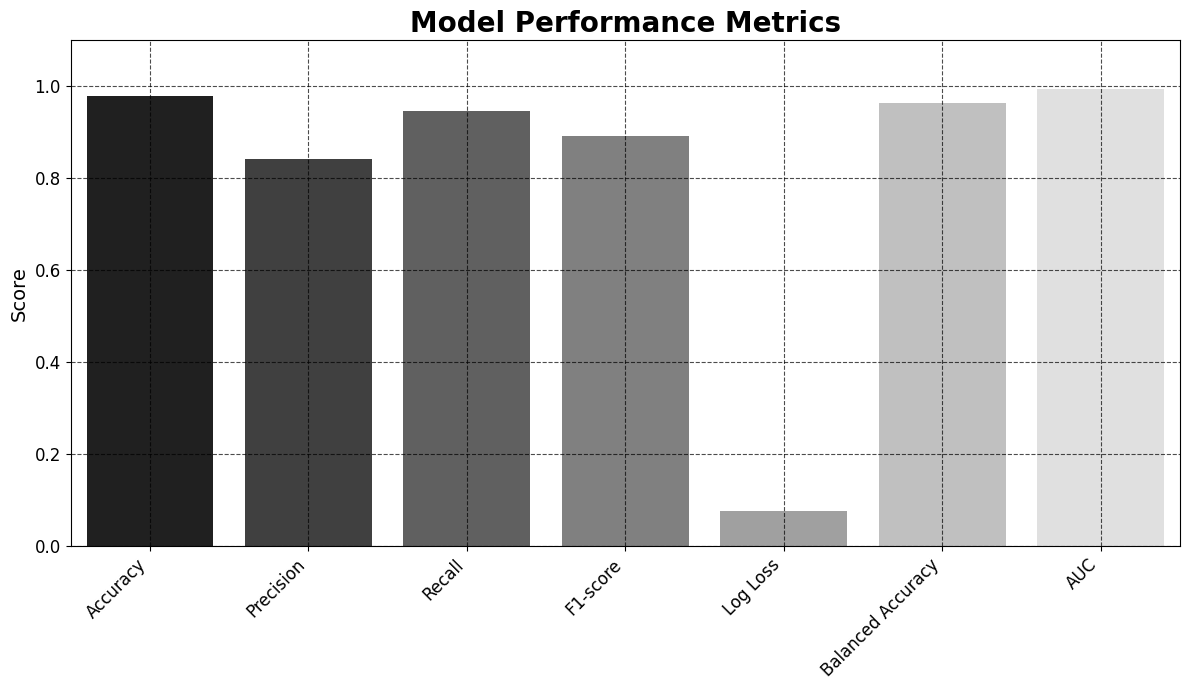

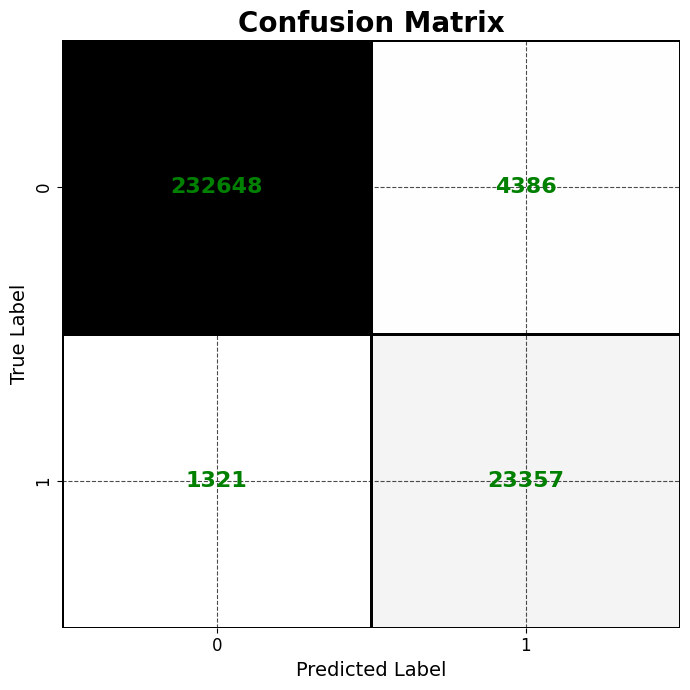

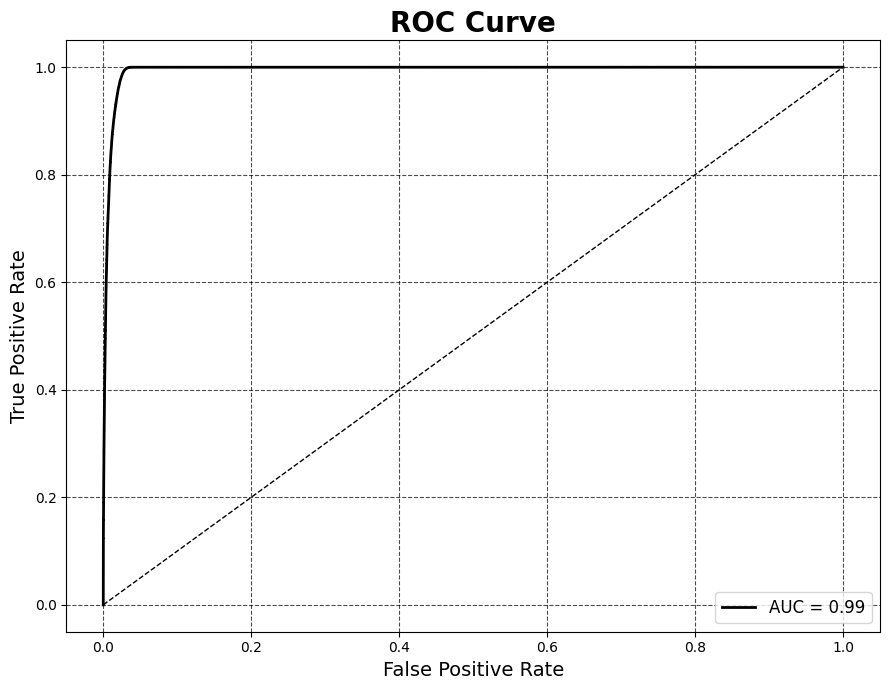

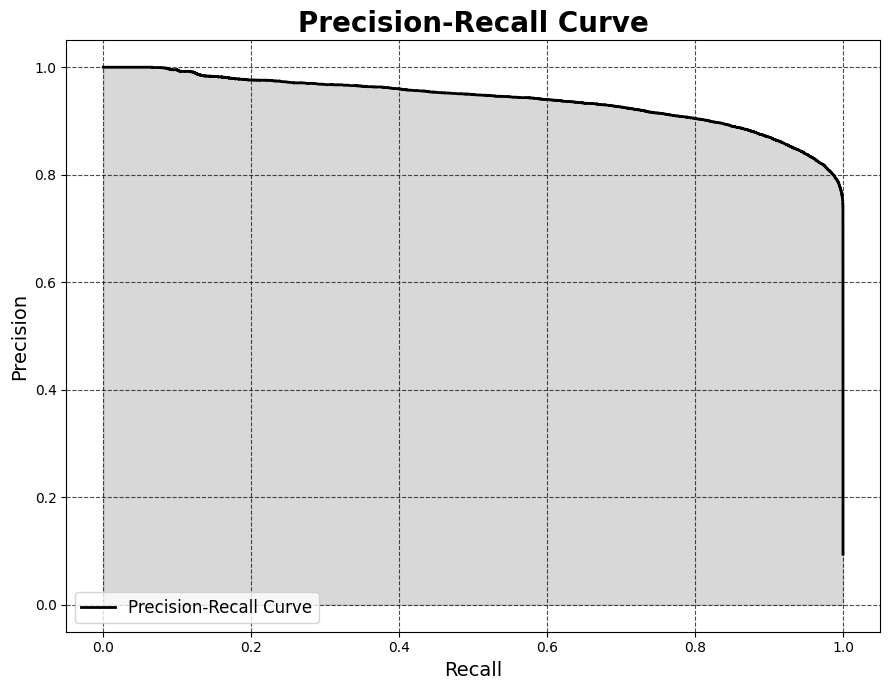

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example metric values (replace these with actual calculated metrics)
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1_sco,
    "Log Loss": logloss,
    "Balanced Accuracy": balanced_acc,
    "AUC": roc_auc
}

# Ensure all metric values are scalars (convert any arrays to scalars using np.mean() or another appropriate method)
for key, value in metrics.items():
    if isinstance(value, np.ndarray):
        metrics[key] = value.mean()  # Taking the mean if it's an array (you can adjust this based on your data)

# Bar plot for performance metrics
plt.figure(figsize=(12, 7))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="gray")
plt.title("Model Performance Metrics", fontsize=20, weight='bold')
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1.1)  # Adjust the Y-axis limits for clarity
plt.grid(True, which='both', linestyle='--', color='black', alpha=0.7)
plt.tight_layout()
plt.show()


# Reshape the labels to match the confusion matrix shape


# Confusion Matrix heatmap with labels
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='', cmap="Greys", cbar=False, annot_kws={"size": 16, "weight": 'bold', "color": "green"}, linewidth=2, linecolor="black")
plt.title("Confusion Matrix", fontsize=20, weight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', color='black', alpha=0.7)
plt.tight_layout()
plt.show()

# ROC Curve in black-and-white theme
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="black", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="black", lw=1)
plt.title("ROC Curve", fontsize=20, weight='bold')
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, which='both', linestyle='--', color='black', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate precision-recall curve (assuming you have the true labels and predicted probabilities)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Precision-Recall Curve in black-and-white theme
plt.figure(figsize=(9, 7))

# Make sure recall and precision have the same length before plotting
if len(recall) == len(precision):
    plt.plot(recall, precision, label="Precision-Recall Curve", color="black", linewidth=2)
    plt.fill_between(recall, precision, color='gray', alpha=0.3)  # Subtle shaded area
else:
    print("Warning: Recall and Precision arrays have mismatched lengths.")

plt.title("Precision-Recall Curve", fontsize=20, weight='bold')
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True, linestyle='--', color='black', alpha=0.7)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

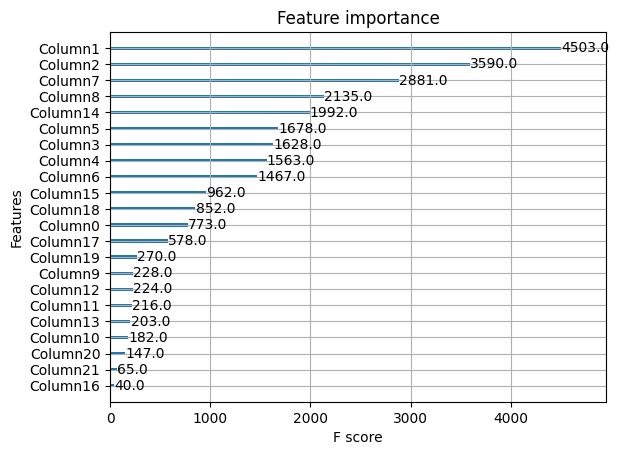

In [20]:
import xgboost as xgb
from xgboost import plot_importance

# Assuming you have an XGBoost model named 'model'
xgb.plot_importance(model)

In [21]:
joblib.dump(model, 'gstn_model.pkl')

['gstn_model.pkl']